# Panama Papers: Discovery of Corruption

* Students: Ilija Gjorgjiev, Gauthier Mueller, Mahmoud Zgolli
* Dataset: Panama Papers

In [70]:
import pandas as pd
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support, precision_score, recall_score, f1_score
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder
from pandas.plotting import scatter_matrix
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from scipy.stats.stats import pearsonr
import seaborn as sns
from scipy import stats
from py2neo import Graph, Node, Relationship
import neo4jupyter
import networkx as nx

%matplotlib inline
import matplotlib as mpl
mpl.style.use("ggplot")


from pputils import *

neo4jupyter.init_notebook_mode()


<IPython.core.display.Javascript object>

In [2]:
#Load Data
panama_entity = pd.read_csv('./Data/panama_papers/panama_papers.nodes.entity.csv', low_memory=False)
panama_officer = pd.read_csv('./Data/panama_papers/panama_papers.nodes.officer.csv', low_memory=False)
panama_edges = pd.read_csv("./Data/panama_papers/panama_papers.edges.csv", low_memory=False)
panama_address = pd.read_csv("./Data/panama_papers/panama_papers.nodes.address.csv", low_memory=False)
panama_intermediary = pd.read_csv("./Data/panama_papers/panama_papers.nodes.intermediary.csv", low_memory=False)

In [3]:
#Convert Date/Time Values
panama_entity['incorporation_date'] = pd.to_datetime(panama_entity['incorporation_date'])
panama_entity['inactivation_date'] = pd.to_datetime(panama_entity['inactivation_date'])
#panama_entity['struck_off_date'] = pd.to_datetime(panama_entity['struck_off_date'])
panama_entity["closed_date"] = pd.to_datetime(panama_entity["closed_date"])

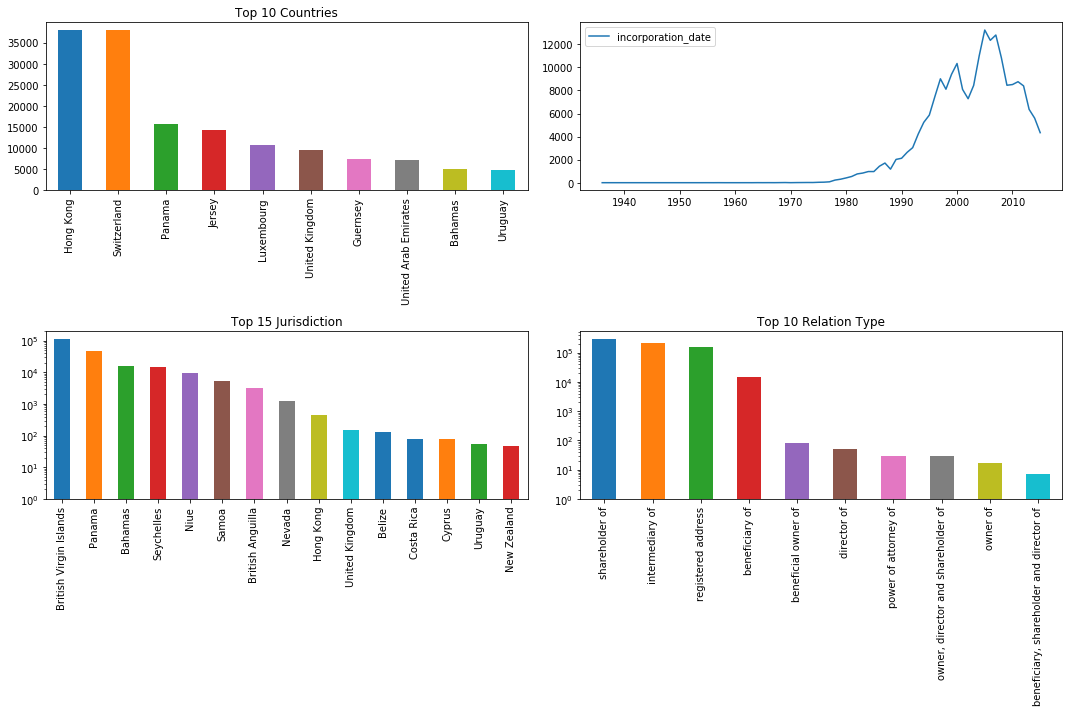

In [41]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15,10))
panama_entity["countries"].value_counts().head(10).plot.bar(title="Top 10 Countries", ax=axes[0,0])
pd.DataFrame(panama_entity['incorporation_date'].dropna().dt.year.astype(int).value_counts()).sort_index().plot.line(ax= axes[0,1])
panama_entity["jurisdiction_description"].value_counts().head(15).plot.bar(log = True, title="Top 15 Jurisdiction", ax = axes[1,0])
panama_edges["link"].value_counts().head(10).plot.bar(log=True, title = "Top 10 Relation Type", ax = axes[1,1])
plt.tight_layout()
plt.show()

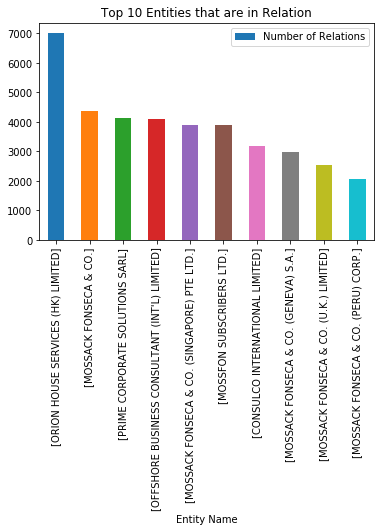

In [37]:
#Get Top 10 Entities that are in Relation
df = panama_edges.groupby('START_ID')['TYPE'].value_counts().to_frame()
df.columns = ["Number of Relations"]
df = df.sort_values(by=["Number of Relations"], ascending = False)
node_ids = df.head(10).copy()
node_ids.reset_index(inplace=True)
names = []
relations = []
#Search for them in Officers, Intermediares or Entities
for i in range(0, 10):
    name = ""
    relations.append(node_ids.loc[i, "TYPE"])
    ID = node_ids.loc[i, "START_ID"]
    if ID in panama_entity["node_id"].values:
        name = panama_entity[panama_entity["node_id"] == ID]["name"]
        names.append(name)
    elif ID in panama_intermediary["node_id"].values:
        name = panama_intermediary[panama_intermediary["node_id"] == ID]["name"]
        names.append(name)
    elif ID in panama_officer["node_id"].values:
        name = (panama_officer[panama_officer["node_id"] == ID]["name"])
        names.append(name)
    else:
        name = panama_address[panama_address["node_id"] == ID]["address"]
        names.append(name)

node_ids["Entity Name"] = pd.Series(names)
node_ids.plot.bar(x = "Entity Name", y = "Number of Relations", title = "Top 10 Entities that are in Relation")



In [175]:
#As we can see most of them are intermediaries.
node_ids.head(10)

,START_ID,TYPE,Number of Relations,Entity Name
0,11001746,intermediary_of,7016,1756 ORION HOUSE SERVICES (HK) LIMITED Name...
1,11011863,intermediary_of,4364,"11862 MOSSACK FONSECA & CO. Name: name, dty..."
2,11012037,intermediary_of,4117,12039 PRIME CORPORATE SOLUTIONS SARL Name: ...
3,11001708,intermediary_of,4094,1722 OFFSHORE BUSINESS CONSULTANT (INT'L) L...
4,11008027,intermediary_of,3888,8031 MOSSACK FONSECA & CO. (SINGAPORE) PTE ...
5,12160432,officer_of,3882,"159573 MOSSFON SUBSCRIBERS LTD. Name: name,..."
6,11009351,intermediary_of,3168,9351 CONSULCO INTERNATIONAL LIMITED Name: n...
7,11007372,intermediary_of,2986,7369 MOSSACK FONSECA & CO. (GENEVA) S.A. Na...
8,11011539,intermediary_of,2538,11543 MOSSACK FONSECA & CO. (U.K.) LIMITED ...
9,11009139,intermediary_of,2055,9145 MOSSACK FONSECA & CO. (PERU) CORP. Nam...


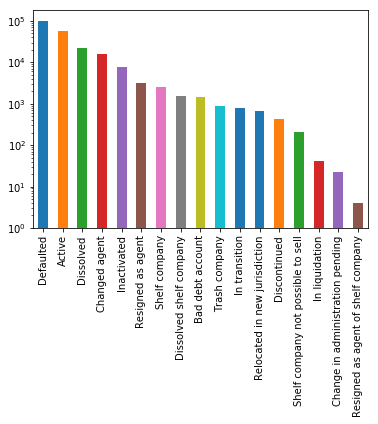

In [185]:
#Top 10 Statuses of Entities
panama_entity["status"].value_counts().plot.bar(log=True)

# Creation of The Graph

First we create the full graph. The edges are directed connections, as they give out information about who is shareholder of, intermediate of, director of, etc. Nodes can be any of addresses, entities, intermediates or officers. This is due to the fact that an entity should have a legal address, and then intermediaries or officers can be person, companies, foundations, etc.

In [82]:
# create graph
G = nx.DiGraph()

for n,row in panama_address.iterrows():
    G.add_node(row.node_id, node_type="address", details=row.to_dict())
    
for n,row in panama_entity.iterrows():
    G.add_node(row.node_id, node_type="entities", details=row.to_dict())
    
for n,row in panama_intermediary.iterrows():
    G.add_node(row.node_id, node_type="intermediates", details=row.to_dict())
    
for n,row in panama_officer.iterrows():
    G.add_node(row.node_id, node_type="officers", details=row.to_dict())
    
for n,row in panama_edges.iterrows():b
    G.add_edge(row['START_ID'], row['END_ID'], rel_type=row.TYPE, details=row.to_dict())

In [85]:
nx.write_adjlist(G,"pp_graph.adjlist")

### Network of King Salman bin Abdulaziz bin Abdulrahman Al Saud - King of Saudi Arabia
In this subsection we will explore the connection of big player name that was found in the panama papers. We will expore the network of King of Saudi Arabia - Salman bin Abdulaziz bin Abdulrahman Al Saud. 

In [83]:
#Explore Network for Tax Evasion Comapnies that are surronded around King Salman bin Abdulaziz bin Abdulrahman Al Saud
kingSaudiArabia = "King Salman bin Abdulaziz bin Abdulrahman Al Saud"

#Check if he actually exists in the data.
panama_officer[panama_officer["name"] == kingSaudiArabia]

,node_id,name,country_codes,countries,sourceID,valid_until,note
238383,15004501,King Salman bin Abdulaziz bin Abdulrahman Al Saud,NaN,NaN,Panama Papers,The Panama Papers data is current through 2015,Record manually added from leaked documents


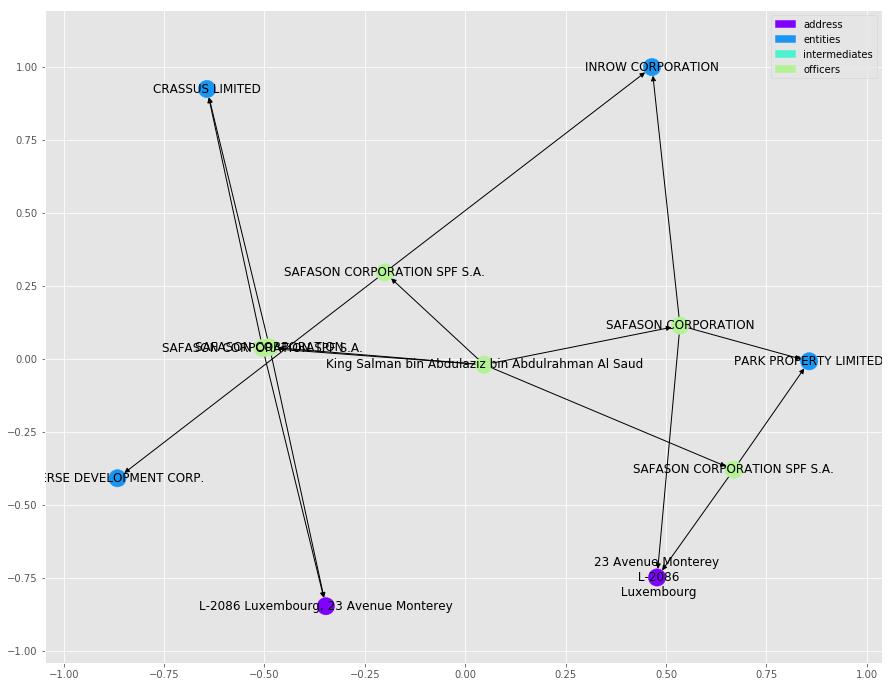

In [93]:
#Create a subgraph(connected component, which will shows with what nodes does the king interact) by BFS
kingGraph = G.subgraph(nx.shortest_path(G, 15004501))
plot_graph(kingGraph, figsize=(15,12))

As we can see the King is connected to a couple of companies all having almost the same name(probably are the same company) which are being officers, the company address is in Luxembourg. these companies are then connected to actual offshore entities. We can see that this SAFASON CORPORATION SPF is connected to various other entties VERSE DEVELOPMENT CORP, CRASSUS LIMITED, PARK PROPERTY LIMITED, CRASSUS LIMITED.

In [102]:
#Expore VERSE DEVELOPENT CORP, 
listOfEntities = ["VERSE DEVELOPMENT CORP.", "PARK PROPERTY LIMITED", "INROW CORPORATION", "CRASSUS LIMITED"] 
display(panama_entity[panama_entity["name"] in listOfEntities])

ValueError: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

We can see that VERSE DEVELOPMENT CORP. was incorporated in 1991 in Panama and that is still active.